# VGG16 Neural Network Analysis

## Environment Setup

In [1]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CLASSES = ['Paul_Gauguin',
 'Edgar_Degas',
 'Vincent_van_Gogh',
 'Albrecht_Dürer',
 'Pablo_Picasso',
 'Titian',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Rembrandt']

TRAIN_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'
TEST_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/test'
VAL_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/val'

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 47
NUM_EPOCHS = 20
PATIENCE = 3

MODEL_DIR = "/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

LOCAL_PATH = "/content/model"

if not os.path.exists(LOCAL_PATH):
    os.makedirs(LOCAL_PATH)

DROPOUT_PERC = 0.5

##  Compute class weights

In [4]:
GENERAL_PATH="/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train"

class_cardinality={}
for it in os.scandir(GENERAL_PATH):
    if it.is_dir():
      class_cardinality[it.name]=len(os.listdir(it.path))

df = pd.DataFrame(class_cardinality.items(), columns=['Name', 'Num_Paintings'])
df["Class_Weight"] = df.Num_Paintings.sum() / (len(CLASSES)*df.Num_Paintings)
CLASS_WEIGHTS = df['Class_Weight'].to_dict()
CLASS_WEIGHTS

{0: 1.258483452031839,
 1: 0.556193297537493,
 2: 0.44549903603737206,
 3: 1.1925367209210005,
 4: 0.889546935149541,
 5: 1.5342185903983656,
 6: 1.3452754142409316,
 7: 1.6352749047359825,
 8: 1.1620889748549323,
 9: 1.508789552988448,
 10: 1.4923000496770988}

## Utility funciton to reuse snippet of code

In [5]:
from sklearn.utils import class_weight
def model_compiler(model, learning_rate = 0.001, my_loss = "sparse_categorical_crossentropy", my_optimizer = "Adam", my_metrics = "accuracy"):
  
  custom_opt = optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss = my_loss, optimizer = custom_opt, metrics = [my_metrics])
  return model

def model_executor(model, model_name, train, validation, epoch_number = 20, patience = 2, class_weights=None):
  model_path = LOCAL_PATH + "/" + model_name + ".h5"
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience),
      keras.callbacks.ModelCheckpoint(filepath = model_path, monitor="val_loss", verbose=1, save_best_only=True)
  ]

  train_history = model.fit(train, validation_data = validation, epochs=epoch_number, callbacks = callbacks, class_weight=class_weights)

  shutil.copy(model_path, MODEL_DIR + "/" + model_name + ".h5")

  return model, train_history

def model_evaluator(model, test):
  model.evaluate(test)

  true_labels = np.concatenate([y for x, y in test], axis=0)
  pred_labels = model.predict(test)
  pred_labels = np.argmax(pred_labels, axis=-1)
  print(classification_report(true_labels, pred_labels, target_names = CLASSES))
  return pred_labels

def confusion_matrix_maker(model, test, pred_labels):

  true_labels = np.concatenate([y for x, y in test], axis=0)
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

def plot_train_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_model_structure(model, name):
    tf.keras.utils.plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

## Dataset Loading

In [6]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)


val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

Found 3004 files belonging to 11 classes.
Found 656 files belonging to 11 classes.
Found 639 files belonging to 11 classes.


## VGG16 with custom classifier

In [ ]:
vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg(x)

x = layers.Flatten(name='flatten')(x)

x = layers.Dense(512,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_2')(x)

output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_test")


model = model_compiler(model, learning_rate=0.0005)
model.summary()

Model: "VGG16_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 512)              1

In [ ]:
model, history = model_executor(model, "NoDropout", training_images, val_images, NUM_EPOCHS, PATIENCE, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 4.6055 - accuracy: 0.5406
Epoch 1: val_loss improved from inf to 1.22061, saving model to /content/model/NoDropout_test.h5
94/94 [==============================] - 22s 222ms/step - loss: 4.6055 - accuracy: 0.5406 - val_loss: 1.2206 - val_accuracy: 0.6729
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.9101
Epoch 2: val_loss did not improve from 1.22061
94/94 [==============================] - 21s 218ms/step - loss: 0.3228 - accuracy: 0.9101 - val_loss: 1.2760 - val_accuracy: 0.7543
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9780
Epoch 3: val_loss improved from 1.22061 to 1.21038, saving model to /content/model/NoDropout_test.h5
94/94 [==============================] - 21s 222ms/step - loss: 0.0740 - accuracy: 0.9780 - val_loss: 1.2104 - val_accuracy: 0.7559
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.0060 - 

Plots of accuracy and loss during training, these can help to recognize overfitting

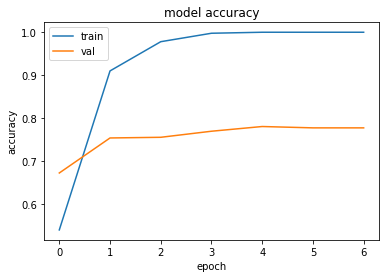

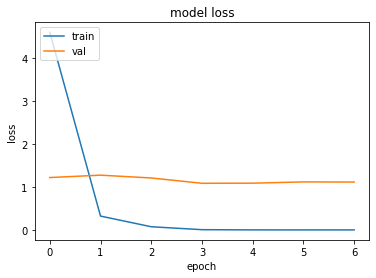

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 169ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.89      0.94      0.91        50
          Edgar_Degas       0.85      0.72      0.78        40
     Vincent_van_Gogh       0.84      0.90      0.87       106
       Albrecht_Dürer       0.71      0.67      0.69        45
        Pablo_Picasso       0.90      0.70      0.79        37
               Titian       0.76      0.79      0.77        67
       Francisco_Goya       0.70      0.65      0.67        48
         Marc_Chagall       0.81      0.67      0.73        51
Pierre-Auguste_Renoir       0.86      0.78      0.82        40
        Alfred_Sisley       0.68      0.77      0.72        39
            Rembrandt       0.79      0.88      0.83       133

             accuracy                           0.80       656
            macro avg       0.80      0.77      0.78       656
         weighted avg       0.80      0.80      0.80       65

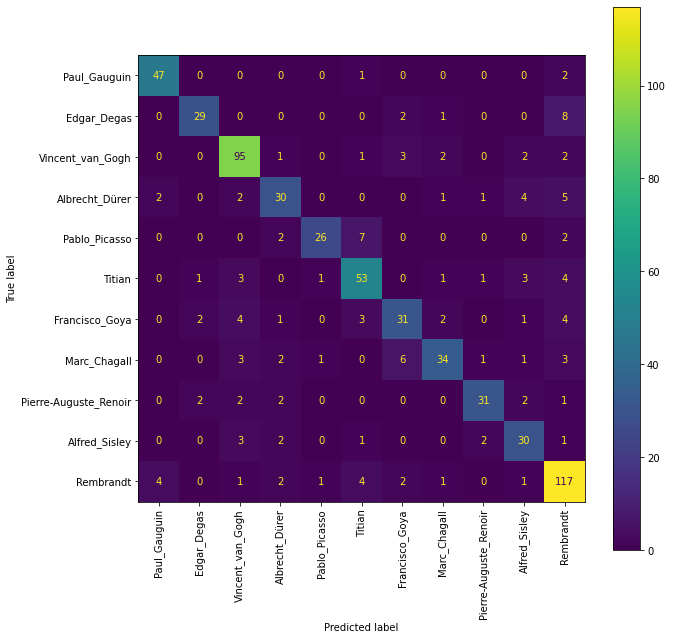

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "VGG_no_dropout")

## VGG16 with Dropout

In [ ]:
vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

vgg.trainable = False
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

We decided to add a dropout layer after each layer to prevent overfitting

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg(x)


x = layers.Flatten(name='flatten')(x)

x = layers.Dense(1024,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_2')(x)
#x = layers.Dropout(0.3)(x)

output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_Dropout")


model = model_compiler(model, learning_rate=0.0008)
model.summary()

Model: "VGG16_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [ ]:
model, history = model_executor(model, "Dropout", training_images, val_images, 20, 5, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 9.6630 - accuracy: 0.5053
Epoch 1: val_loss improved from inf to 1.97403, saving model to /content/model/Dropout.h5
94/94 [==============================] - 23s 233ms/step - loss: 9.6630 - accuracy: 0.5053 - val_loss: 1.9740 - val_accuracy: 0.6808
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.6995 - accuracy: 0.7780
Epoch 2: val_loss did not improve from 1.97403
94/94 [==============================] - 20s 211ms/step - loss: 1.6995 - accuracy: 0.7780 - val_loss: 2.2193 - val_accuracy: 0.6948
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.8562
Epoch 3: val_loss improved from 1.97403 to 1.96056, saving model to /content/model/Dropout.h5
94/94 [==============================] - 22s 229ms/step - loss: 0.9072 - accuracy: 0.8562 - val_loss: 1.9606 - val_accuracy: 0.7512
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.89

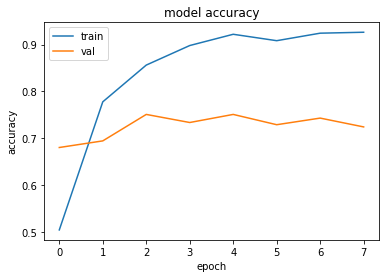

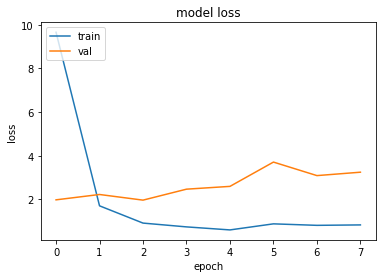

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 174ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.94      0.64      0.76        50
          Edgar_Degas       0.70      0.88      0.78        40
     Vincent_van_Gogh       0.90      0.77      0.83       106
       Albrecht_Dürer       0.67      0.69      0.68        45
        Pablo_Picasso       0.54      0.78      0.64        37
               Titian       0.67      0.73      0.70        67
       Francisco_Goya       0.81      0.27      0.41        48
         Marc_Chagall       0.57      0.80      0.67        51
Pierre-Auguste_Renoir       0.67      0.78      0.72        40
        Alfred_Sisley       0.81      0.56      0.67        39
            Rembrandt       0.75      0.83      0.79       133

             accuracy                           0.72       656
            macro avg       0.73      0.70      0.69       656
         weighted avg       0.75      0.72      0.72       65

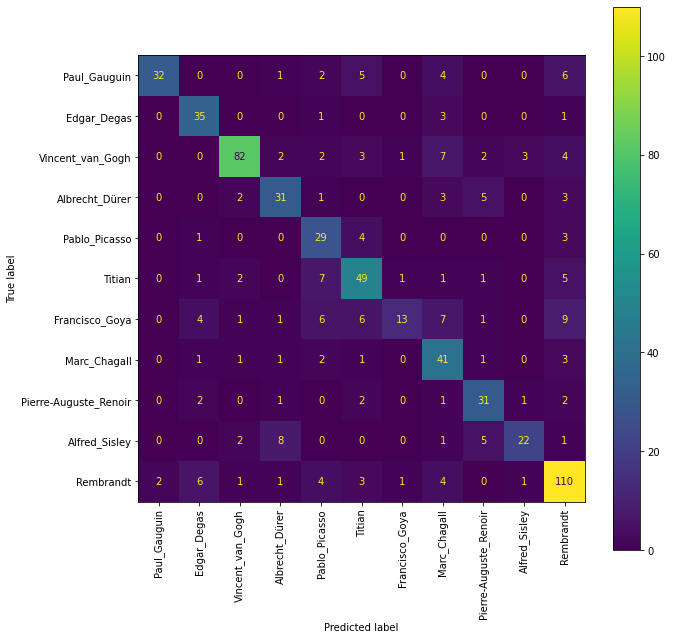

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "VGG_dropout")

## Fine Tuning

We use the model with Dropout since it has the highest performances, we will make the same analysis unfreezing more layers simultaneously 

In [7]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights/Dropout.h5', compile=False)

### Unfreezing of the last layer

In [8]:
trainable = False
for layer in model.get_layer("vgg16").layers:
  if layer.name == 'block5_conv3':
      trainable = True
  layer.trainable = trainable

model = model_compiler(model, 0.0001)

model.summary()

Model: "VGG16_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [ ]:
model, history = model_executor(model, "Dropout_Last_Layer", training_images, val_images, 20, 5)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.9377
Epoch 1: val_loss improved from inf to 1.91902, saving model to /content/model/Dropout_Last_Layer.h5
94/94 [==============================] - 561s 5s/step - loss: 0.3292 - accuracy: 0.9377 - val_loss: 1.9190 - val_accuracy: 0.7293
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9694
Epoch 2: val_loss improved from 1.91902 to 1.46506, saving model to /content/model/Dropout_Last_Layer.h5
94/94 [==============================] - 17s 176ms/step - loss: 0.1360 - accuracy: 0.9694 - val_loss: 1.4651 - val_accuracy: 0.7919
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9777
Epoch 3: val_loss did not improve from 1.46506
94/94 [==============================] - 16s 165ms/step - loss: 0.0855 - accuracy: 0.9777 - val_loss: 1.5568 - val_accuracy: 0.7825
Epoch 4/20
31/94 [========>.....................] - ETA: 8s - loss: 0.0

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16/Dropout_Last_Layer.h5')

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "Unfreeze_Last_Layer")

### Unfreezing of the last layer  (classifier not trainable) learning_rate=0.0001

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights/Dropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
  if layer.name == 'block5_conv3':
      trainable = True
  layer.trainable = trainable

In [ ]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense_1").trainable = False

In [ ]:
model = model_compiler(model, 0.0001)

model.summary()

Model: "VGG16_Dropout_Regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1

In [ ]:
model, history = model_executor(model, "Dropout_Last_Layer_class_blocked", training_images, val_images, 20, 5)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 6.0913 - accuracy: 0.9008 
Epoch 1: val_loss improved from inf to 6.44847, saving model to /content/model/Dropout_Last_Layer_class_blocked.h5
94/94 [==============================] - 1400s 14s/step - loss: 6.0913 - accuracy: 0.9008 - val_loss: 6.4485 - val_accuracy: 0.8075
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 5.9856 - accuracy: 0.9411
Epoch 2: val_loss did not improve from 6.44847
94/94 [==============================] - 17s 179ms/step - loss: 5.9856 - accuracy: 0.9411 - val_loss: 6.4582 - val_accuracy: 0.8216
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 5.9393 - accuracy: 0.9571
Epoch 3: val_loss improved from 6.44847 to 6.39938, saving model to /content/model/Dropout_Last_Layer_class_blocked.h5
94/94 [==============================] - 17s 181ms/step - loss: 5.9393 - accuracy: 0.9571 - val_loss: 6.3994 - val_accuracy: 0.8185
Epoch 4/20
94/94 [======================

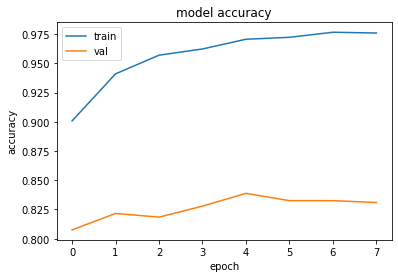

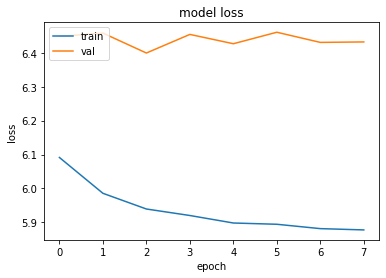

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 134ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.98      0.94      0.96        50
          Edgar_Degas       0.86      0.80      0.83        40
     Vincent_van_Gogh       0.80      0.95      0.87       106
       Albrecht_Dürer       0.82      0.69      0.75        45
        Pablo_Picasso       0.82      0.73      0.77        37
               Titian       0.82      0.75      0.78        67
       Francisco_Goya       0.76      0.60      0.67        48
         Marc_Chagall       0.81      0.67      0.73        51
Pierre-Auguste_Renoir       0.72      0.82      0.77        40
        Alfred_Sisley       0.74      0.67      0.70        39
            Rembrandt       0.80      0.91      0.85       133

             accuracy                           0.81       656
            macro avg       0.81      0.78      0.79       656
         weighted avg       0.81      0.81      0.81       65

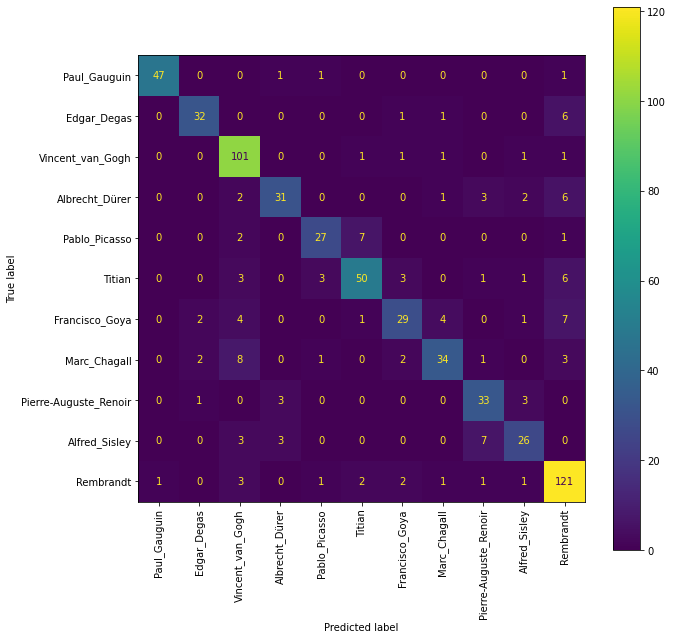

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "Unfreeze_Last_Layer")

### Unfreezing of the last layer  (classifier not trainable) learning_rate=0.000001

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights/Dropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
  if layer.name == 'block5_conv3':
      trainable = True
  layer.trainable = trainable

In [ ]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense_1").trainable = False

In [ ]:
model = model_compiler(model, 0.000001)
model.summary()

Model: "VGG16_Dropout_Regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1

In [ ]:
model, history = model_executor(model, "Dropout_Last_Layer_class_blocked_learning", training_images, val_images, 40, 3)

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 6.1392 - accuracy: 0.8908
Epoch 1: val_loss improved from inf to 6.50791, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 19s 184ms/step - loss: 6.1392 - accuracy: 0.8908 - val_loss: 6.5079 - val_accuracy: 0.7731
Epoch 2/40
94/94 [==============================] - ETA: 0s - loss: 6.1138 - accuracy: 0.8915
Epoch 2: val_loss improved from 6.50791 to 6.48625, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 17s 180ms/step - loss: 6.1138 - accuracy: 0.8915 - val_loss: 6.4863 - val_accuracy: 0.7887
Epoch 3/40
94/94 [==============================] - ETA: 0s - loss: 6.1027 - accuracy: 0.8968
Epoch 3: val_loss improved from 6.48625 to 6.47044, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 17s 178ms/step - loss: 6.1027 - a

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16/Dropout_Last_Layer_class_blocked_learning.h5')

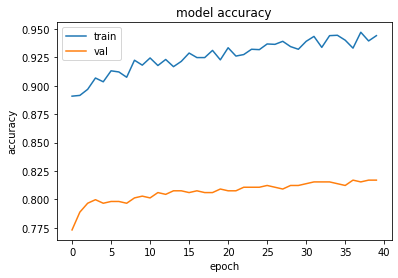

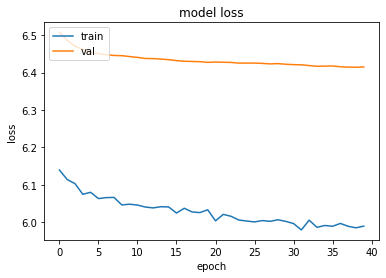

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 135ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.87      0.96      0.91        50
          Edgar_Degas       0.78      0.80      0.79        40
     Vincent_van_Gogh       0.79      0.91      0.84       106
       Albrecht_Dürer       0.85      0.64      0.73        45
        Pablo_Picasso       0.72      0.78      0.75        37
               Titian       0.84      0.70      0.76        67
       Francisco_Goya       0.77      0.62      0.69        48
         Marc_Chagall       0.74      0.67      0.70        51
Pierre-Auguste_Renoir       0.73      0.88      0.80        40
        Alfred_Sisley       0.71      0.74      0.72        39
            Rembrandt       0.81      0.82      0.82       133

             accuracy                           0.79       656
            macro avg       0.78      0.78      0.78       656
         weighted avg       0.79      0.79      0.79       65

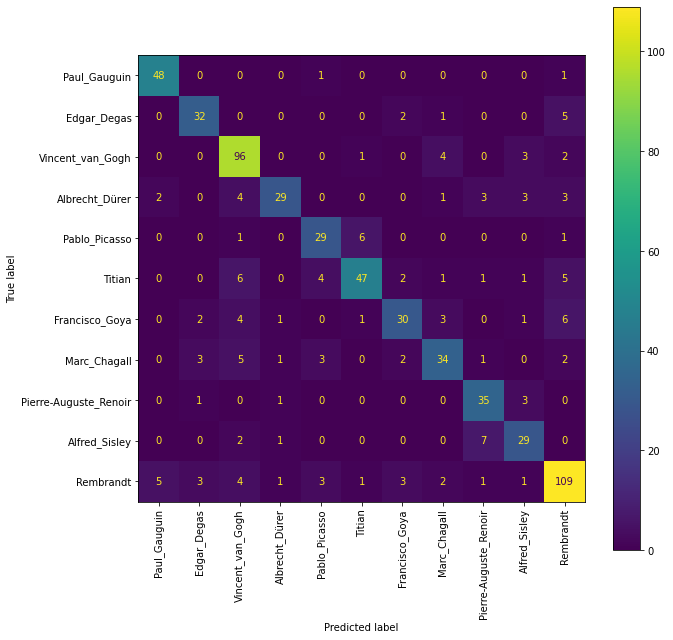

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing of the last layer  (classifier not trainable) learning_rate=0.000001

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights/Dropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
  if layer.name == 'block5_conv3':
      trainable = True
  layer.trainable = trainable

In [ ]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense_1").trainable = False

In [ ]:
model = model_compiler(model, 0.000001)
model.summary()

In [ ]:
model, history = model_executor(model, "Dropout_Last_Layer_class_blocked_learning", training_images, val_images, 40, 3)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 4.7262 - accuracy: 0.8928
Epoch 1: val_loss improved from inf to 4.35508, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 475s 5s/step - loss: 4.7262 - accuracy: 0.8928 - val_loss: 4.3551 - val_accuracy: 0.7950
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 3.7992 - accuracy: 0.9081
Epoch 2: val_loss improved from 4.35508 to 4.09487, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 23s 243ms/step - loss: 3.7992 - accuracy: 0.9081 - val_loss: 4.0949 - val_accuracy: 0.7950
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 3.6640 - accuracy: 0.9055
Epoch 3: val_loss improved from 4.09487 to 4.01060, saving model to /content/model/Dropout_Last_Layer_class_blocked_learning.h5
94/94 [==============================] - 23s 238ms/step - loss: 3.6640 - acc

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16/Dropout_Last_Layer_class_blocked_learning.h5')

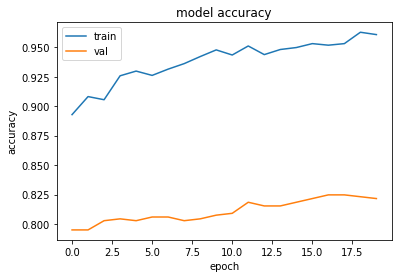

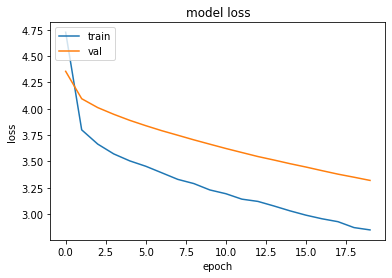

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 173ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.87      0.96      0.91        50
          Edgar_Degas       0.82      0.80      0.81        40
     Vincent_van_Gogh       0.78      0.91      0.84       106
       Albrecht_Dürer       0.81      0.67      0.73        45
        Pablo_Picasso       0.82      0.76      0.79        37
               Titian       0.77      0.73      0.75        67
       Francisco_Goya       0.76      0.65      0.70        48
         Marc_Chagall       0.82      0.65      0.73        51
Pierre-Auguste_Renoir       0.74      0.88      0.80        40
        Alfred_Sisley       0.68      0.72      0.70        39
            Rembrandt       0.84      0.85      0.84       133

             accuracy                           0.80       656
            macro avg       0.79      0.78      0.78       656
         weighted avg       0.80      0.80      0.79       65

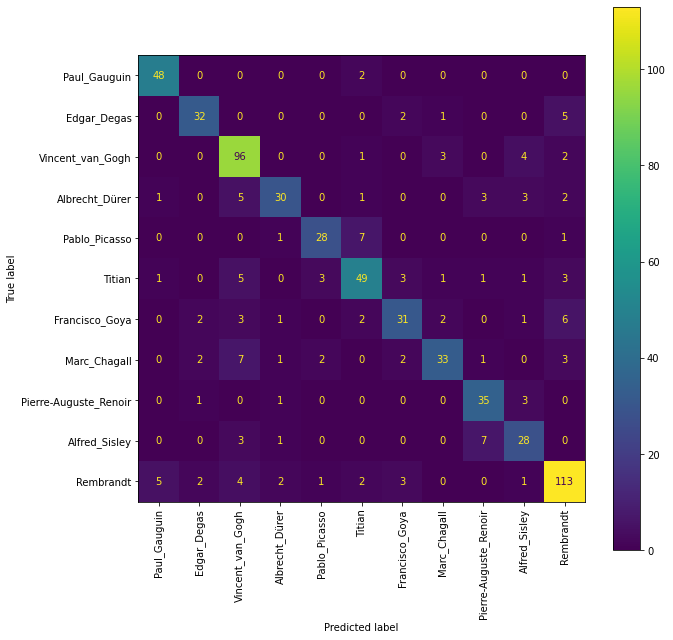

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "Unfreeze_Last_Layer")